# 21M.387 Fundamentals of Music Processing
## Beat Detection 2

In this lecture: another popular beat detection algorithm using dynamic programming, and beat-synchronous features

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['image.interpolation'] = 'nearest'

fmp.documentation_button()

## Reading

Chapter 6.3 (pp 328 – 341)

<img src="images/book_cover.png" width=200>

## Beat Tracking by Dynamic Programming

- Assumes a mostly steady beat.
- Assumes beats generally coincide with large values of the novelty function $\Delta[n]$ (Note: you could use any way of arriving at $\Delta[n]$, like the energy-method $\Delta^e[n]$, or the spectral method $\Delta^s[n]$. Generally though, $\Delta^s[n]$ is superior as shown in the previous lecture).
- Requires an estimate of what the general tempo is.

<font color='red'>__Whiteboard__</font>: Beat Score

The goal is to create a _beat sequence_. Let's call that $B$:  
$B = (b_1, b_2, b_3, ... b_L)$

Each $b_l$ is a _beat location_ - an index in the novelty function $\Delta[n]$.  
There are $L$ beats in the beat sequence.

We want to balance two factors:

1. Beat locations should line up with large values of $\Delta[n]$.
1. The delta between any two consecutive beats should be close to $\hat \delta$, the _beat interval_.

$\hat \delta$ is the tempo estimate in units of samples (so it is an integer), aka the estimated period. To compute it:  
Assuming $\hat \tau$ is the tempo estimate in BPM and $F_f$ is the sampling rate of $\Delta[n]$:  
$$\hat \delta = \lceil F_f \cdot {60 \over \hat \tau} \rfloor $$

Next, we construct $\mathbf{S}$, a _Score Function_ that lets us evaluate a beat sequence $B$.

$\mathbf{S}(B) = [\text{beats align with onsets}] + \lambda [\text{beat spacing} \simeq \hat \delta]$

For the first part:
$\sum_{l=1}^L \Delta[b_l]$

For the second part:
$\sum_{l=2}^L P_{\hat \delta}(b_l - b_{l-1})$

What should $P_{\hat \delta}(\delta)$ be?

It should be a function that is large when $\delta = \hat \delta$, and should gradually fall off when $\delta$ gets bigger or smaller than $\hat \delta$:


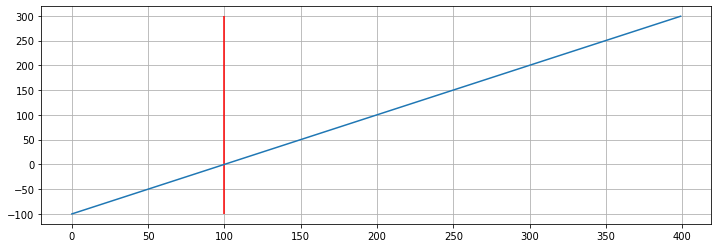

In [2]:
# TODO: try some different ideas to create penalty function:

period = 100
p = np.arange(0, 400)
penalty = p - period
plt.plot(p, penalty)
plt.vlines(period, np.min(penalty), np.max(penalty), 'r')
plt.grid()
plt.show()


<img src="images/delta_penalty.png" width=600>

$$P_{\hat \delta}(\delta) = -(\log_2(\delta / \hat \delta))^2$$

It is a _logarithmic function_. Half-tempo produces the same penalty has double-tempo.

So, the beat-score function for a particular series of beats $B$ is:  
$$\mathbf{S}(B) = \sum_{l=1}^L \Delta[b_l] + \lambda \sum_{l=2}^L P_{\hat \delta}(b_l - b_{l-1})$$


Example:

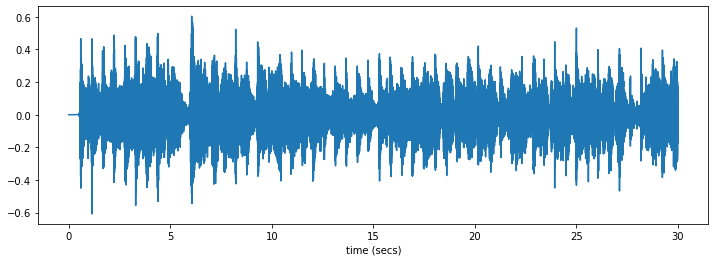

In [3]:
snd1 = fmp.load_wav("audio/beatles_being_for_the_benefit_of_mr_kite.wav", 0, 30)
fs = 22050
fmp.plot_and_listen("audio/beatles_being_for_the_benefit_of_mr_kite.wav", 30)

Create the spectral novelty function with parameters:
- $N=1024$
- $H=512$
- $\gamma=10$

feature rate = 43.07Hz


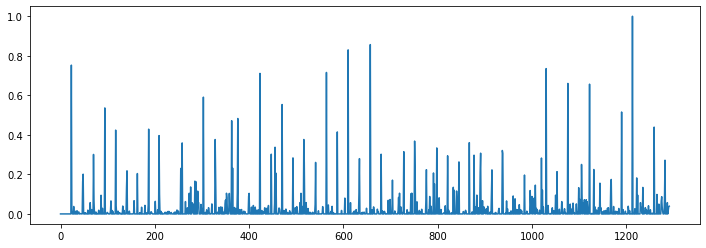

In [4]:
win_len = 1024
hop_size = 512
gamma = 10
nov1 = fmp.spectral_novelty(snd1, win_len, hop_size, gamma)
ff = fs / float(hop_size)
print(f"feature rate = {ff:.2f}Hz")
plt.plot(nov1);

The tempo of this song is approximately 111 BPM. We assume this for now, and we will show how to compute it later on.

So: $\hat \tau = 111$

In [5]:
bpm1 = 111.
est_period1 = ff * 60 / bpm1
print(f"period = {est_period1:.2f} samples")
est_period1 = int(round(est_period1))
print(f"rounded to = {est_period1:d} samples")

period = 23.28 samples
rounded to = 23 samples


The function `fmp.beats_score(nov, beats, est_period, lmbda)` calculates the score for how good the beats are given a novelty function.

Each example beat sequence below has its own beat score.

In [6]:
@interact(period=fmp.slider(est_period1-6, est_period1+6), offset=fmp.slider(0, est_period1))
def test_beats_score(period, offset) :
    num = int(len(nov1) / period) - 1
    beats = np.arange(num) * period + offset
    beats = beats.astype(int)

    plt.plot(nov1)
    plt.vlines(beats, 0, 1, 'r')
    score = fmp.beats_score(nov1, beats, est_period1)
    txt = f'score = {score:.3f}' 
    plt.text(0, 1.1, txt, fontsize=15)
    plt.show()

interactive(children=(IntSlider(value=17, continuous_update=False, description='period', max=29, min=17), IntS…

Now, we have an optimization problem:

Given the score function $\mathbf{S}(B)$, and all possible beat sequences, find the beat sequence $B^*$ that maximizes  $\mathbf{S}(B)$.

$$B^* = \text{argmax}\lbrace \mathbf{S}(B) \mid B \in \mathcal{B}^N\rbrace$$

## Dynamic Programming

The number of different beat sequences is ridiculously large. It is exponential in $N$, the number of "beat slots".

In [7]:
dur = 2
num_slots = int(dur * ff)
print(f"N={num_slots} slots for novelty function of {dur} seconds")
print(f"number of beat sequences: {2 ** num_slots}")

N=86 slots for novelty function of 2 seconds
number of beat sequences: 77371252455336267181195264



Like we did in Dynamic Time Warping, we can use dynamic programming to find the optimal sequence without trying them all.

Similar technique to DTW: 
- work on local sub-problems
- accumulate local score into a global vector

### Accumulated Score Vector $\mathbf{D}$

Define a vector $\mathbf{D}$ of length $N$ where each element:
$$\mathbf{D}[n] = \max \lbrace \mathbf{S}(B) \mid B \in \mathcal{B}^N_n \rbrace$$

where $\mathcal{B}^N_n$ is the set of all beat sequences ending at position $n$.

$\mathbf{D}[n]$ is the accumulated score vector. It stores the _score_ of the best (highest scoring) beat sequence ending at position $n$.

Caution: $\Delta[n] \mid n \in [1:N]$ whereas $\mathbf{D}[n] \mid n \in [0:N]$. The $n=0$ position is not part of the signal. It is used as a special marker to indicate the end of the algorithm.

$\mathbf{D}[n]$ is calculated as follows:

Initialize with $\mathbf{D}[0] = 0$ and $\mathbf{D}[1] = \Delta[1]$

Next, compute each value of $\mathbf{D}[n]$, for $n \in [2:N]$:

$$
\mathbf{D}[n] = \Delta[n] + \max
\begin{cases}
0,  \\
\max_{m \in [1:n-1]} \lbrace \mathbf{D}[m] + \lambda P_{\hat \delta}(n - m)\rbrace \\
\end{cases}
$$

The important step above is the inner $\max$ statement. It allows the current time-step $n$ to be "arrived at" from the best possible previous location (which has the highest accumulated score combined with the smallest penalty). Think of it like this: what's the best way to get _here_ $[n]$ coming from _over there_ $[1:n-1$]?

The outer $\max$ statement handles the trivial case of only one beat ($L = 1$).

Finally, in order to actually discover the optimal beat sequence $B^*$, we must remember which location ($m$) produced the maximizing score above and store that in a backtracking vector $\mathbf{P}$. And if $\mathbf{D}[n] = \Delta[n]$ (i.e., the case of one beat), we set $\mathbf{P}[n] = 0$, which terminates the backtracking.



Backtracking begins at the highest accumulated score which is $b_L = \underset{n} {\operatorname{argmax}} \mathbf{D}[n]$, the final beat of the optimal beat sequence, and follows $\mathbf{P}[n]$ back to $n=0$.

### Example

Here is a toy example. 

For simplicity, we use $\lambda = 1$ and $P_{\hat \delta}(\delta) = - (\delta - \hat \delta)^2$ and $\hat \delta = 3$
<img src="images/dyn_prog_toy.png" width=700>

## Estimating Global Tempo

One strategy for estimating the global tempo $\hat \tau$ is to create a tempogram and average all the columns into one column:

$$ f[k] = { 1 \over N} \sum_{n=1}^{N} \mathcal{F}[n,k] $$


Here is the tempogram:

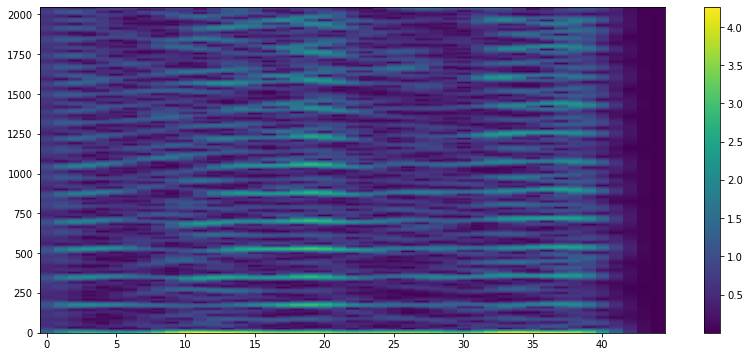

In [8]:
win_len_tg = 256
zp_tg = 16
hop_tg = 32
fft_len = win_len_tg * zp_tg
tg = np.abs(fmp.stft(nov1, win_len_tg, hop_tg, zp_tg))

plt.figure(figsize=(14, 6))
plt.imshow(tg, origin='lower', aspect='auto')
plt.colorbar()
plt.show()

Average across all rows:

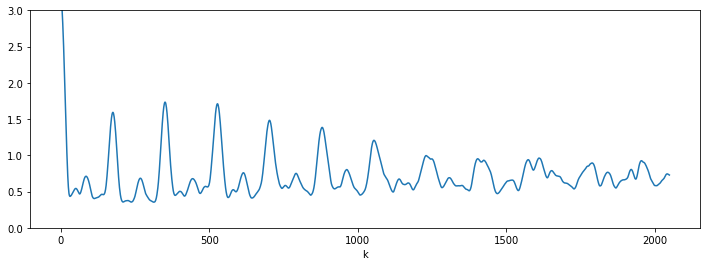

In [9]:
ave_tg = np.mean(tg, axis = 1)
plt.plot(ave_tg)
plt.ylim(0,3)
plt.xlabel('k')
plt.show()

Pick the maximum, but only from a pre-specified tempo range. 


$$ k = \underset{k \in [k_{min} : k_{max}]} {\operatorname{argmax}} \{ f[k] \} $$

Convert peak at bin $k$ to tempo (BPM) with:
$$ \tau_k = k \cdot 60 \cdot {F_f \over N_{tg} \cdot Z_{tg} }$$

And finally, convert tempo into period with:
$$\hat \delta = \lceil F_f \cdot {60 \over \hat \tau} \rfloor $$

For example, with a tempo constraint of 40 BPM to 200 BPM:

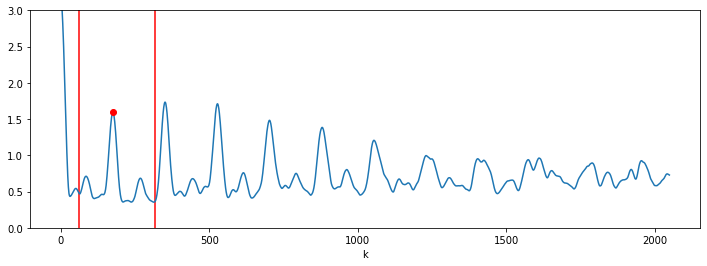

estimated BPM: 111.03057861328125
estimated period: 23


In [10]:
bpm_min = 40
bpm_max = 200
bpm1 = fmp.estimate_bpm(nov1, ff, bpm_min, bpm_max)
est_period1 = int(round(60 * ff / bpm1))

k_min = fmp.bpm_to_k(bpm_min, fft_len, ff)
k_max = fmp.bpm_to_k(bpm_max, fft_len, ff)
k_peak = fmp.bpm_to_k(bpm1, fft_len, ff)

plt.plot(ave_tg)
plt.vlines((k_min, k_max), 0, 3, 'r')
plt.plot(k_peak, ave_tg[k_peak], 'ro')
plt.ylim(0,3)
plt.xlabel('k')
plt.show()

print(f'estimated BPM: {bpm1}')
print(f'estimated period: {est_period1}')

## Beat Tracking Examples

Now that we have the estimated period, run the Dynamic Programming Beat Tracker
(with $\lambda = 10$)

(0.0, 500.0)

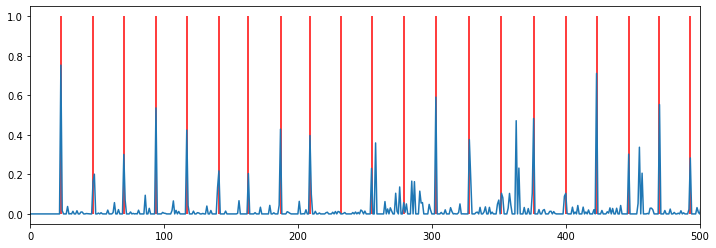

In [11]:
beats = fmp.create_dp_beats(nov1, est_period1, 10)[0]
plt.plot(nov1)
plt.vlines(beats, 0, 1, 'r')
plt.xlim(0, 500)

In [12]:
def play_beats(beats, hop_size, snd, fs):
    beat_locs = (beats * hop_size).astype(int)
    click_snd = fmp.load_wav("audio/click.wav")
    clicks = fmp.make_clicks(beat_locs, len(snd), click_snd)
    return ipd.Audio([snd * 0.2, clicks], rate = fs)

play_beats(beats, hop_size, snd1, fs)

### The Effect of Changing $\lambda$

including small errors in $\hat \delta$.

In [13]:
def show_and_play_beats(nov, period, lmda, snd, hop_size, fs):
    beats = fmp.create_dp_beats(nov, period, lmda)[0]
    plt.figure()
    plt.plot(nov)
    plt.vlines(beats, 0, 1, 'r');
    plt.xlim(0, 500)
    text = f"$\lambda = {lmda:.1f}$   $\delta = {period}$"
    plt.text(0, 1.1, text, fontsize=20)
    plt.show()
    return play_beats(beats, hop_size, snd, fs)

@interact(lmda_idx=(0, 2), period_err=(-2, 2))
def test_beat_track(lmda_idx, period_err = 0):
    est_p = est_period1 + period_err
    lmda = (0.2, 5, 30)[lmda_idx]
    return show_and_play_beats(nov1, est_p, lmda, snd1, hop_size, fs)

interactive(children=(IntSlider(value=1, description='lmda_idx', max=2), IntSlider(value=0, description='perio…

### Another Example

_Chameleon_ by Herbie Hancock

In [14]:
snd2 = fmp.load_wav("audio/hancock_chameleon.wav", 0, 60)
nov2 = fmp.spectral_novelty(snd2, win_len, hop_size, 10)
bpm2 = fmp.estimate_bpm(nov2, ff, 40, 150)
est_period2 = int(round(60 * ff / bpm2))
print(est_period2)

27


In [15]:
@interact(lmda_idx=fmp.slider(0, 3))
def test_beat_track(lmda_idx):
    lmda = (1, 5, 10, 15)[lmda_idx]
    return show_and_play_beats(nov2, est_period2, lmda, snd2, hop_size, fs)    

interactive(children=(IntSlider(value=0, continuous_update=False, description='lmda_idx', max=3), Output()), _…

## Beat Synchronized Features

Another applicaiton of beat tracking is to help improve other feature calculations

In [16]:
snd3 = fmp.load_wav("audio/bach_prelude13.wav", 0, 20) * 4
ipd.Audio(snd3, rate = fs)

Chromagram of the first 10 seconds:

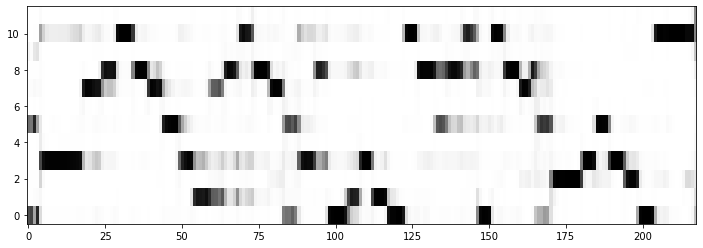

In [17]:
chroma = fmp.make_chromagram(snd3[:int(fs*10)], fs, 4096, 1024, gamma=0)
plt.imshow(chroma, origin='lower', aspect='auto', cmap='Greys');

Find beats by dynamic programming

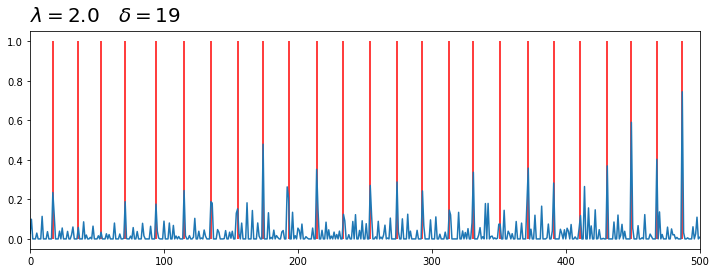

In [18]:
win_len3 = 512
hop_size3 = 256
nov3 = fmp.spectral_novelty(snd3, win_len3, hop_size3, 1)
ff3 = fs / hop_size3
est_bpm3 = fmp.estimate_bpm(nov3, ff3, 200, 400)
est_period3 = int(round(ff3 * 60 / est_bpm3))
beats3 = fmp.create_dp_beats(nov3, est_period3, 2.)[0]
beat_locs3 = (beats3 * hop_size3).astype(int)
show_and_play_beats(nov3, est_period3, 2, snd3, hop_size3, fs)

Create a customized chromagram based on a _non-uniform_ spacing of the STFT.

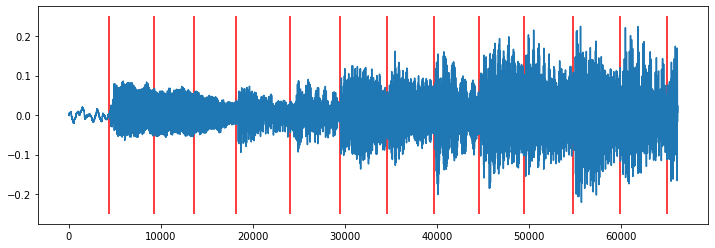

In [19]:
plt.plot(snd3[0:int(fs*3)])
plt.vlines(beat_locs3[:13], -0.25, .25, 'r')
plt.show()

Find the maximum beat length to figure out $N$ for the STFT.

- $N = $ next power of 2 above max beat length
- $H$ is not a constant - hops vary according to the detected beats
- Use zero-padding up to $N$ as needed
- This method has no overlapping windows

In [20]:
def sync_stft(x, sync, fft_len):
    num_hops = len(sync) - 1
    num_bins = fft_len // 2 + 1

    output = np.empty((num_bins, num_hops), dtype = complex)

    for h in range(num_hops):
        start = sync[h]
        end = sync[h+1]
        wlen = end - start
        sig = x[start:end] * np.hanning(wlen)
        sig.resize(fft_len) # this will zero-pad to the correct length
        
        # take real FFT
        output[: , h] = np.fft.rfft(sig)
    return output

longest beat: 5888
fft_len: 8192


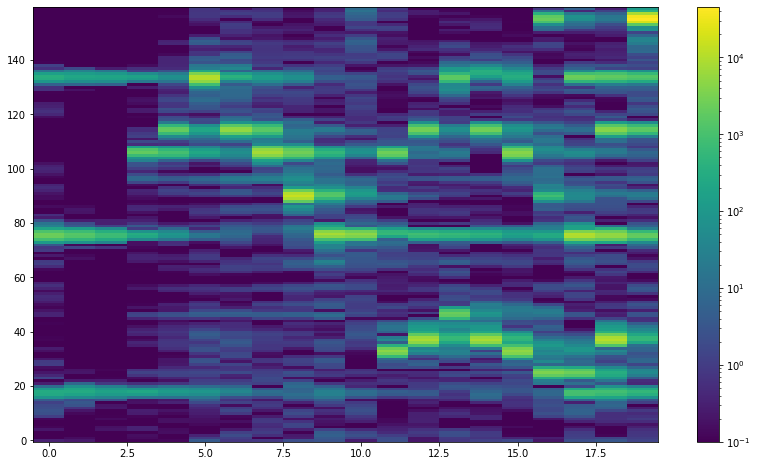

In [21]:
longest_beat = np.max(beat_locs3[1:] - beat_locs3[:-1])
fft_len3 = int(2 ** np.ceil(np.log2(longest_beat)))

print('longest beat:',  longest_beat)
print('fft_len:', fft_len3)

spec = np.abs(sync_stft(snd3, beat_locs3, fft_len3)) ** 2
plt.figure(figsize=(14, 8))
# fmp.plot_spectrogram(spec[0:600,])
fmp.plot_spectrogram(spec[40:200,:20])

Use this spectrogram to make a chormagram

In [22]:
def make_sync_chormagram(snd, fs, sync, normalize = True, gamma = 0):
    # find max window size:
    fft_len = np.max(sync[1:] - sync[:-1])

    # round up to next power of 2:
    fft_len = int(2 ** np.ceil(np.log2(fft_len)))
    
    c_fp = fmp.spec_to_pitch_mtx(fs, fft_len, type='hann')
    c_pc = np.tile(np.identity(12), 11)[:, 0:128]
    spec = np.abs(sync_stft(snd, sync, fft_len))
    
    chroma = np.dot(np.dot(c_pc, c_fp), spec ** 2)
    if gamma > 0:
        chroma = np.log(1 + gamma * chroma)
        
    if normalize:
        length = np.linalg.norm(chroma, axis=0, ord = 2)
        chroma = chroma / length
    return chroma

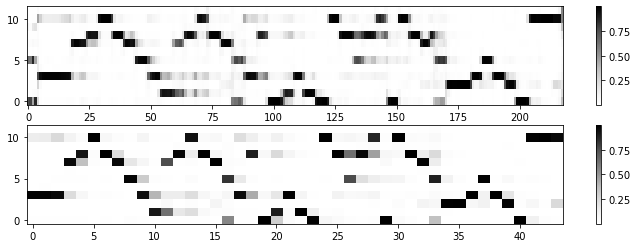

In [23]:
chroma_sync = make_sync_chormagram(snd3, fs, beat_locs3[:45])
fmp.plot_two_chromas(chroma, chroma_sync)